In [1]:
import os
import cv2
import numpy as np
import torch
# network configurations
from configuration import Configuration
from net.mask_rcnn import MaskRcnnNet
# visualize utils
import matplotlib as mpl
import matplotlib.pyplot as plt
from net.utils.draw import draw_boxes, instances_to_contour_overlay
%matplotlib inline

## Preprocess

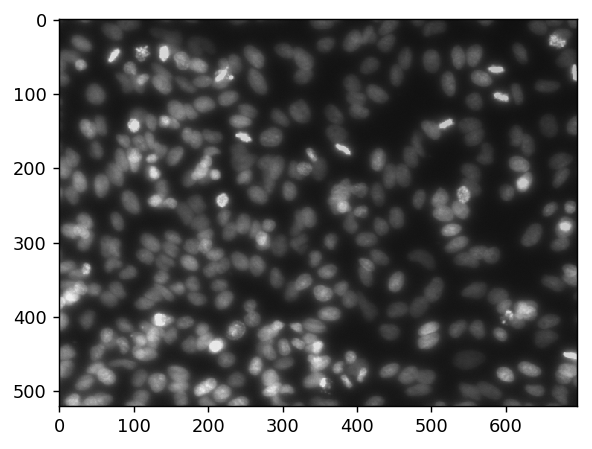

In [2]:
mpl.rcParams['figure.dpi'] = 128 # set higher dpi
cfg = Configuration()  # init configurations
image = cv2.imread('data/dsb2018/images/0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1.png', cv2.IMREAD_COLOR)
plt.imshow(image)  # pick one image. What a mess. Could our model work?

In [3]:
# image read from opencv is arranged as (Height, Width, Channels), we need to 
# convert it into (C, H, W) using transpose, and then normalize it by dividing 255
input_tensor = torch.from_numpy(image.transpose((2, 0, 1))).float().div(255)
# we should wrap the image in a batch before feed into the network
channel, height, width = input_tensor.size()
input_tensor = input_tensor.view(1, channel, height, width)
input_tensor.size()

torch.Size([1, 3, 520, 696])

## Init NetWork

In [4]:
# init network from pretrained model!
net = MaskRcnnNet(cfg).to(cfg.device)
net.load_pretrain('00021000_model.pth')

In [5]:
# run prediction! it will take a few seconds if you use cpu
net.set_mode('test')
with torch.no_grad():
    net(input_tensor.to(cfg.device))

## Predict Masks

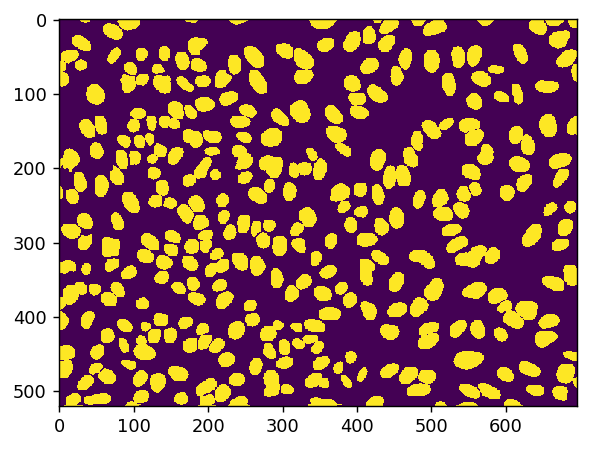

In [6]:
# get the first mask from the batch!
mask = net.masks[0]
mpl.rcParams['figure.dpi'] = 128
plt.imshow(mask != 0)

## Probability Map

In [7]:
# the prob map is stored in self.mask_instances
# it's a (B, N, H, W) array, each one stores one instance, 
# a total of N instances in each batch. let's get the first batch since there's only one image
instances = net.mask_instances[0]
instances.shape

(333, 520, 696)

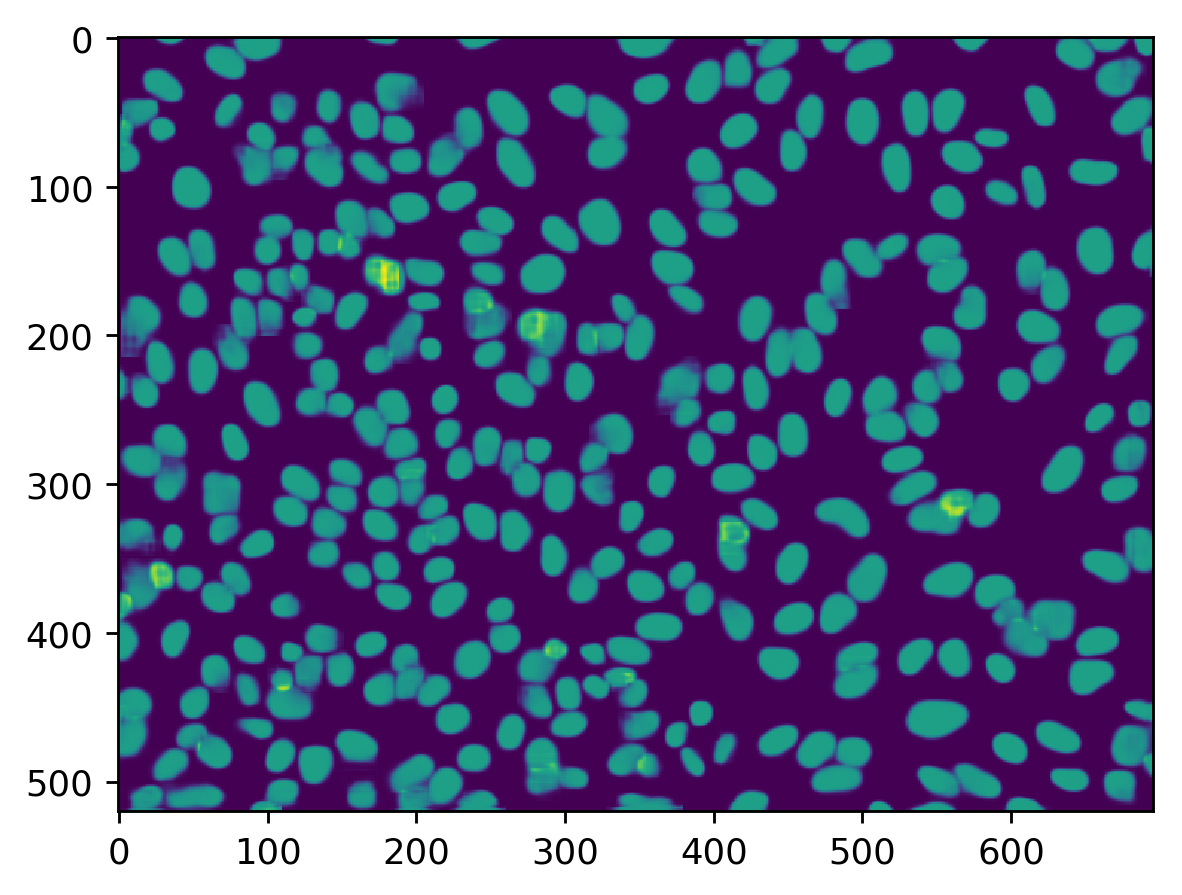

In [8]:
# what about the probability map?
# let's stack all the probability maps on one canvas and plot them
canvas = np.zeros(instances[0].shape)
for instance in net.mask_instances[0]:
    canvas += instance
mpl.rcParams['figure.dpi'] = 256
plt.imshow(canvas)

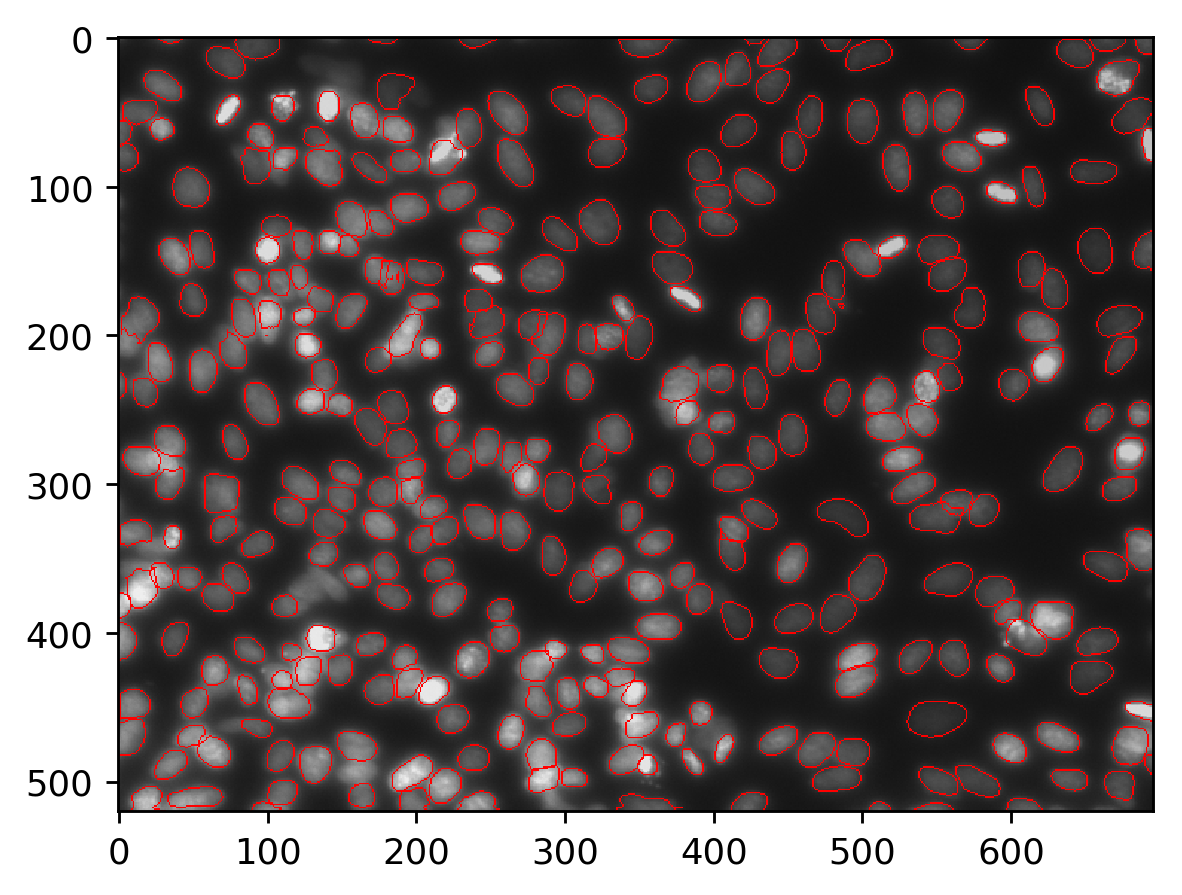

In [9]:
# compare results with truth
# convert prob into binary 0 and 1
binary = (instances > 0.5).astype(np.int8)
# draw countour
countour = instances_to_contour_overlay(binary, image, color=[255, 0, 0])
plt.imshow(countour)

# Region Proposals

In [10]:
# what about boxes?
boxes = net.detections[:, 1:5].numpy()
# take a look of the boxes, they are [x0, y0, x1, y1]
boxes[:10]

array([[584., 463., 615., 492.],
       [426., 405., 463., 436.],
       [543.,  95., 574., 126.],
       [ 66., 256.,  92., 288.],
       [438., 335., 469., 372.],
       [647., 242., 673., 269.],
       [ 31.,  82.,  67., 120.],
       [635.,  77., 677., 105.],
       [484.,  36., 517.,  77.],
       [207., 230., 233., 256.]], dtype=float32)

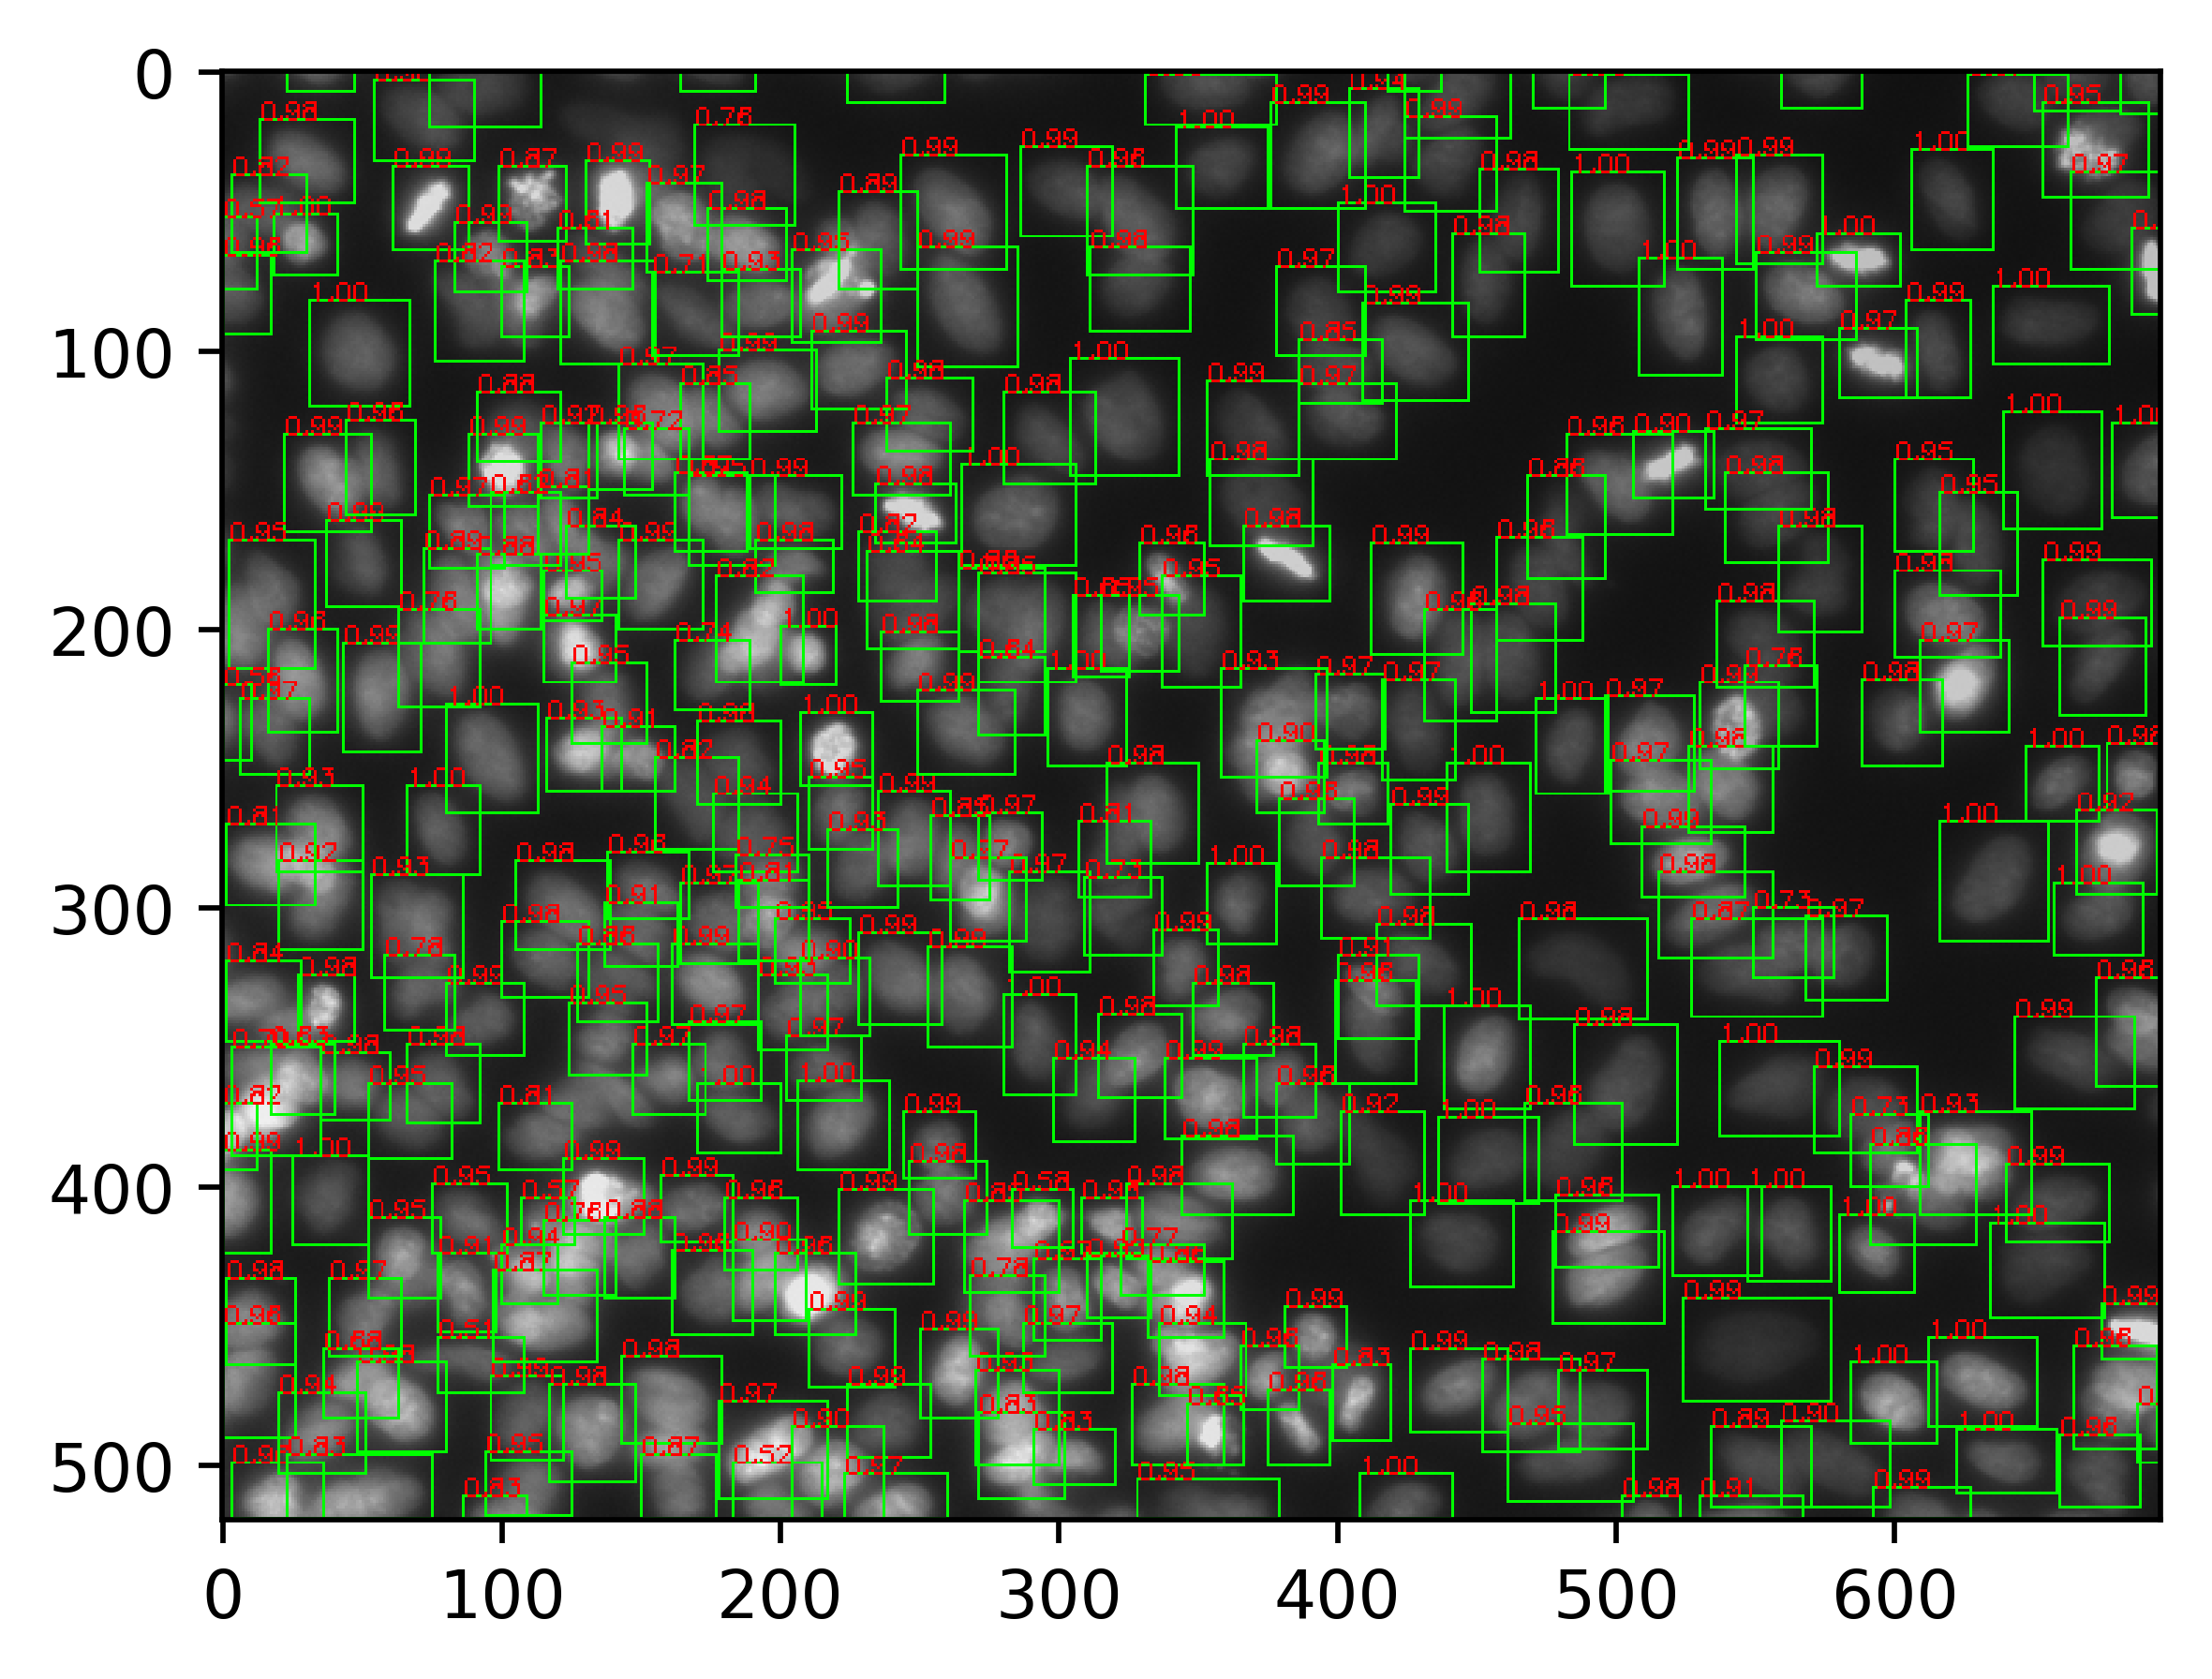

In [11]:
from net.utils.draw import draw_proposals
mpl.rcParams['figure.dpi'] = 512
draw_proposals(image, net.detections, color=(0, 255, 0))
plt.imshow(image)